In [159]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib import pyplot
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import datetime as datetime

## Time Series libraries
from scipy import stats
from statsmodels import tsa
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose

## Auto Arima library
import pmdarima as pm
from pmdarima.arima import ARIMA

## Arma library
from statsmodels.tsa.arima_model import ARMA 
from statsmodels.tsa.statespace.sarimax import SARIMAX

## ignore warnings
import warnings
warnings.filterwarnings('ignore')

## math libraries
from numpy import log
from sklearn.metrics import mean_squared_error

## Problem 2

This Dataset contain more that 629 million rows so as we can see that data set is huge but for now I will consider working with 170000 rows in the dataset.   
This dataset has 2 coloumns:   
acoustic_data - the seismic signal [int16]   
time_to_failure - the time (in seconds) until the next laboratory earthquake [float64]   

In [2]:
data = pd.read_csv("C:/Users/nisar/OneDrive/Desktop/Depaul/CSC-425_TimeSeriesAndForecasting/Final Project/train.csv",nrows=690000)

In [3]:
data = data[:170000]
data.head(2)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691


In [4]:
#create a series for seismic data from train data
seismic = data.acoustic_data
ttf = data.time_to_failure

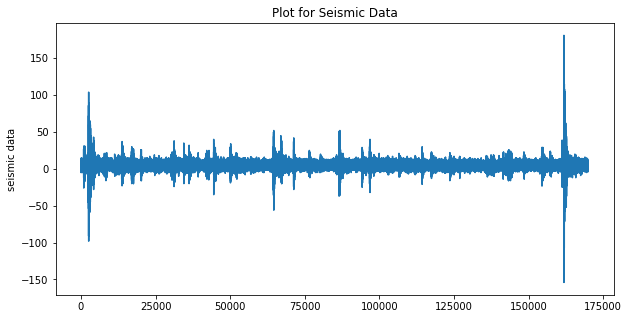

In [5]:
#plot the time series
plt.figure(figsize=(10,5))
seismic.plot()
plt.title('Plot for Seismic Data')
plt.ylabel('seismic data')
plt.show()

In [6]:
s_series = seismic[:175000]

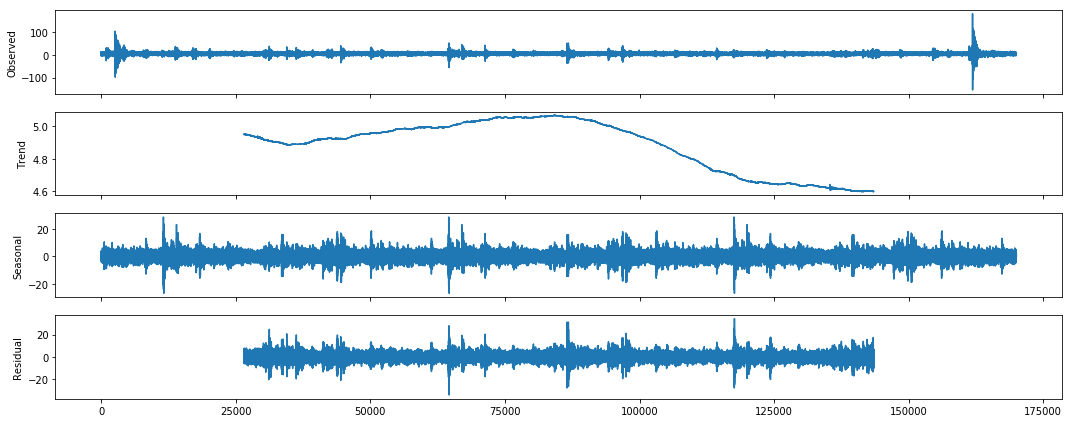

In [7]:
plt.figure(figsize=(12,8))
result_freq = seasonal_decompose(s_series, model='additive', freq=53000)
result_freq.plot()
plt.show()

### 1) Dickey-Fuller test on Raw data.

In [6]:
## for seismic(acoustic data)
result = adfuller(seismic,regression='nc')

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.618159
p-value: 0.000000
Critical Values:
	1%: -2.566
	5%: -1.941
	10%: -1.617


#### Discussion:-
For now we will do the Dickey-Fuller test on the raw data. This test show us that data is stationary and as the value -5.618 is smaller the critical values. More negative the ADF statistic value more the stationarity.     
The p-value for this test is < 0.05. So we will reject the null hypothesis and we can say from the above result that data is stationary and does not have unit roots.

I have use the 'nc' term for the Dickey-Fuller test that is 'no constant' and 'no trend'. 

#### ACF and PACF plots

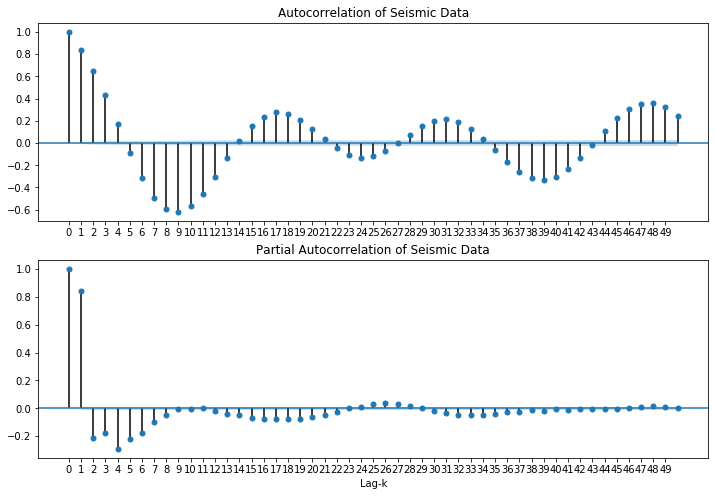

In [8]:
nlags=50  #define number of lags to plot on ACF/PACF plots
data_acf = seismic[:50000]
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = tsaplots.plot_acf(data_acf, lags=nlags, ax=ax1,title='Autocorrelation of Seismic Data')
plt.xticks(list(range(0,nlags)))

ax2 = fig.add_subplot(212)
fig = tsaplots.plot_pacf(data_acf, lags=nlags, ax=ax2,title='Partial Autocorrelation of Seismic Data')
plt.xticks(list(range(0,nlags)))
plt.xlabel('Lag-k')
plt.show()

As we can see that the raw data show some seasonality in it so we will try to de-sesonalize the data by doing "Seasonal Adjustment with Differencing". This will give us clear picture on what values to select for the building the model on the dataset.

#### De-Seasonalizing the data

In [213]:
seismic_data_ma = seismic.rolling(20).mean()

In [63]:
seismic_data_ma.rename(columns={'0':'seismic'},inplace=True)
seismic_data_ma = seismic_data_ma.dropna()

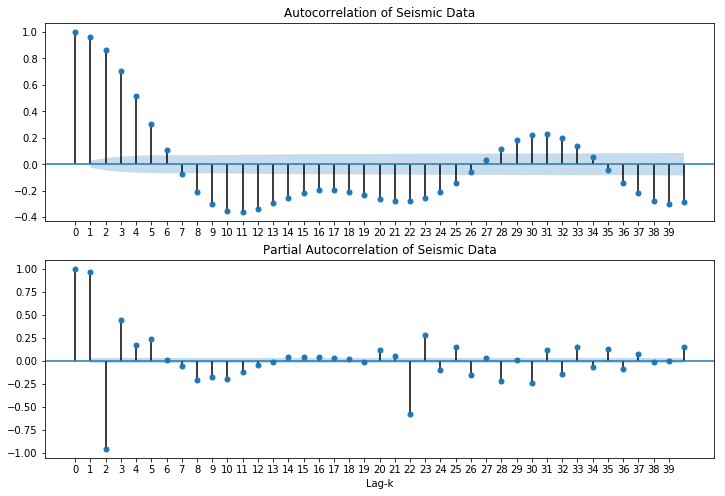

In [64]:
nlags=40  #define number of lags to plot on ACF/PACF plots
seismic_data_ma_acf = seismic_data_ma[:5000]
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = tsaplots.plot_acf(seismic_data_ma_acf, lags=nlags, ax=ax1,title='Autocorrelation of Seismic Data')
plt.xticks(list(range(0,nlags)))

ax2 = fig.add_subplot(212)
fig = tsaplots.plot_pacf(seismic_data_ma_acf, lags=nlags, ax=ax2,title='Partial Autocorrelation of Seismic Data')
plt.xticks(list(range(0,nlags)))
plt.xlabel('Lag-k')
plt.show()

For now we tried different methods like 'first difference', 'log values' and 'rolling average'.   
So far we can see that rolling average decrease the seasonality as we can see from the plot that seasonality is not completely removed but decreased.   
We will now use dickey fuller on this data.

In [503]:
result = adfuller(seismic_data_ma)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.031606
p-value: 0.040388
Critical Values:
	1%: -2.566
	5%: -1.941
	10%: -1.617


#### Building Model

In [208]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults

In [70]:
mod = ARIMA(seismic_data_ma,order=(5,0,5)) ## for moving average of 25
result = mod.fit(disp = 0)

In [14]:
mod2 = ARIMA(seismic, order=(2,0,0))
result2 = mod2.fit(disp = -1)

In [193]:
model_2 = SARIMAX(seismic, order=(2,0,0), seasonal_order=(0,0,0,0))
result_model2 = model_2.fit(disp=0)

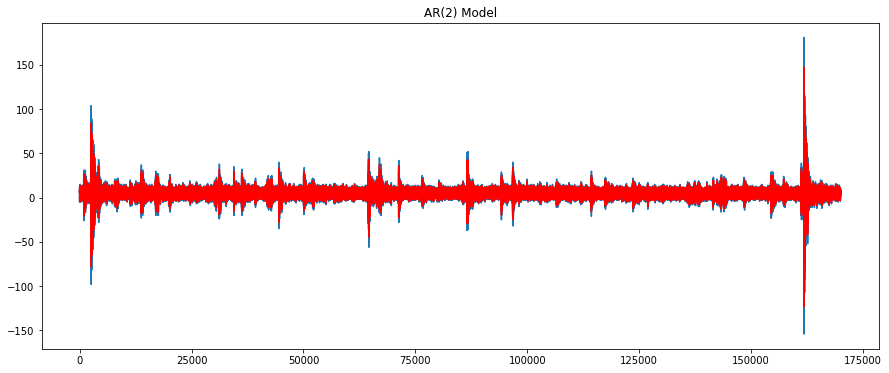

In [211]:
plt.plot(seismic)
plt.plot(result2.fittedvalues, color = 'red')
plt.title("AR(2) Model")

#### Solution:- 
Now we will try to build the model. For now we can see from the plot that we can use raw data or modified data both the data show stationarity. We proved that using dickey fuller.

Firstly, we build the model using AR(2) model using raw data as we can see that the PACF for raw data at 1,2 show sign of high correlation.   
Secondly, I tried different method and for now I am using Moving Average with window of 25. Using that data from the ACF/PACF plot I build the ARIMA model with order (5,0,5) as we can see that this model is bit larger we will keep it for now.

I am trying to forecast using AR(2) model my colleague will try different model.

#### c) Plot the residual of the model and forecasting the model.

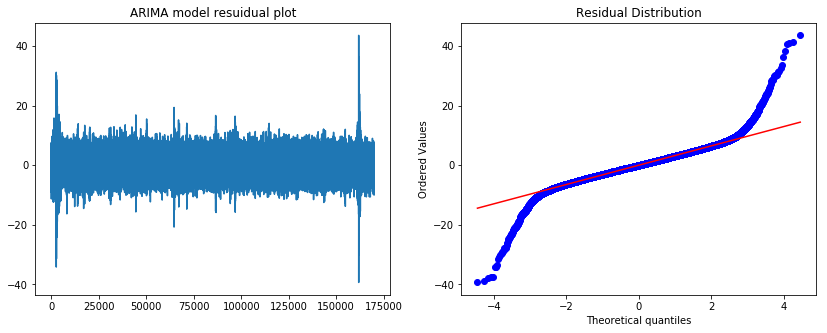

In [16]:
residuals = result2.resid

plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(residuals)
plt.title("ARIMA model resuidual plot")

plt.subplot(122)
stats.probplot(residuals,plot=plt)
plt.title('Residual Distribution')
plt.show()

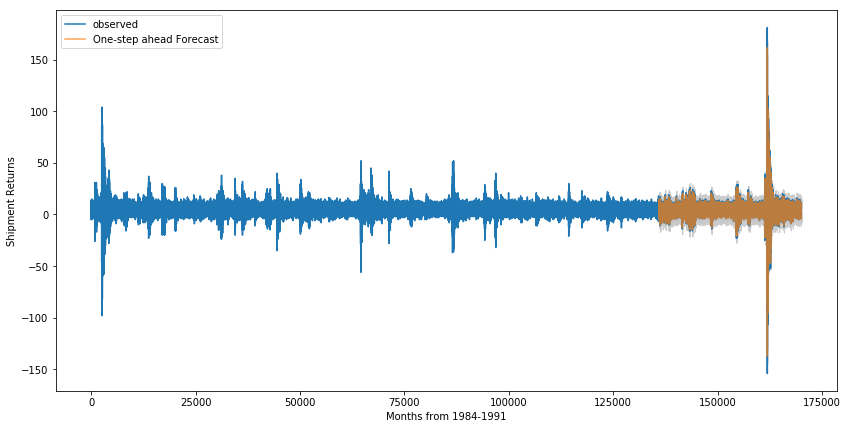

In [197]:
pred = result_model2.get_prediction(start=136000, dynamic=False)
pred_ci = pred.conf_int()
ax = seismic[0:].plot(label='observed')  ## you can adjust the slice value, I will keep it 60 for now
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Months from 1984-1991')
ax.set_ylabel('Shipment Returns')
plt.legend()
plt.show()

#### Solution:-
As we can see that residual of this model has mostly uniform thickness with some shocks and the Q-Q plot show residuals are not normally distributed.

For this AR(2) model we did some backtesting with 80-20 split so as we can see the validate the forecast it shapes similar to original values. For next assigment we will take this model building into details as we will try to cover as many cases as we can. 

## Problem 3

In [7]:
consump = pd.read_csv("consump.csv", parse_dates=['date'], index_col='date')
consump.head(2)

,consump,sent,pers_inc,unemp
date,,,,
2000-01-01,31111,112.0,7999.7,4.0
2000-02-01,31208,111.3,8077.7,4.1


In [8]:
consump = consump[['consump']]
print(consump.shape)
consump_data = consump.consump
print(consump_data.shape)

(168, 1)
(168,)


### a) Time Plot of the consump variable and its behavior over time.

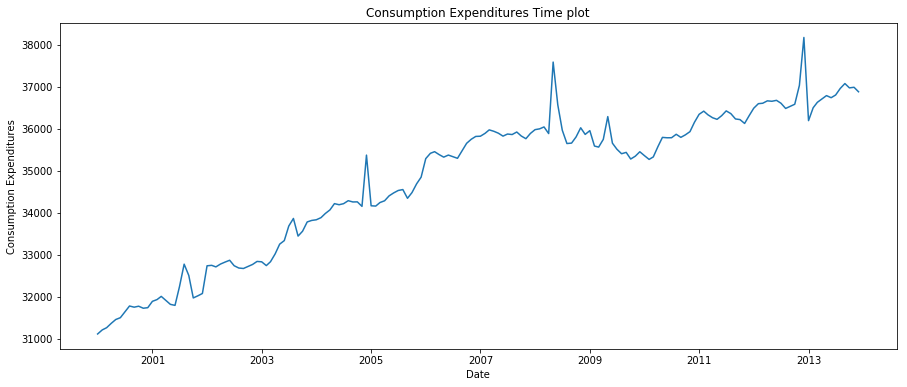

In [9]:
plt.xlabel('Date')
plt.ylabel('Consumption Expenditures')
plt.title('Consumption Expenditures Time plot')
plt.plot('consump', data = consump)

#### Solution:-
As we can see trend from the plot that value of comsump variable increases over the year [2000-2013]. We can see some shocks in between that spike up the price for certain time then it came down again.   
As we can see from the graph that it behavious doesn't look stationary.

#### b) Plot the ACF function (20 lags) of consump.

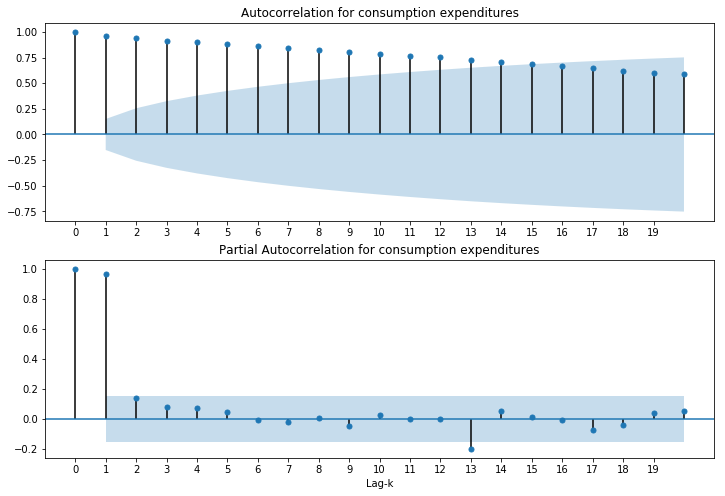

In [404]:
nlags = 20 #define number of lags to plot on ACF/PACF plots
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = tsaplots.plot_acf(consump_data, lags=nlags, ax=ax1,title='Autocorrelation for consumption expenditures')
plt.xticks(list(range(0,nlags)))

ax2 = fig.add_subplot(212)
fig = tsaplots.plot_pacf(consump_data, lags=nlags, ax=ax2,title='Partial Autocorrelation for consumption expenditures')
plt.xticks(list(range(0,nlags)))
plt.xlabel('Lag-k')
plt.show()

#### Solution:-
As we can see from the ACF and PACF plot the series is a 'random walk' series. So it shows the non-stationary behaviour but we will try to de-trend and de-seasonalize the series.   


#### c) Plot the ACF function (20 lags) of the first difference of consump.

In [11]:
consump_diff = consump_data.diff() ##first difference
consump_diff = consump_diff.dropna() ## drop nan values

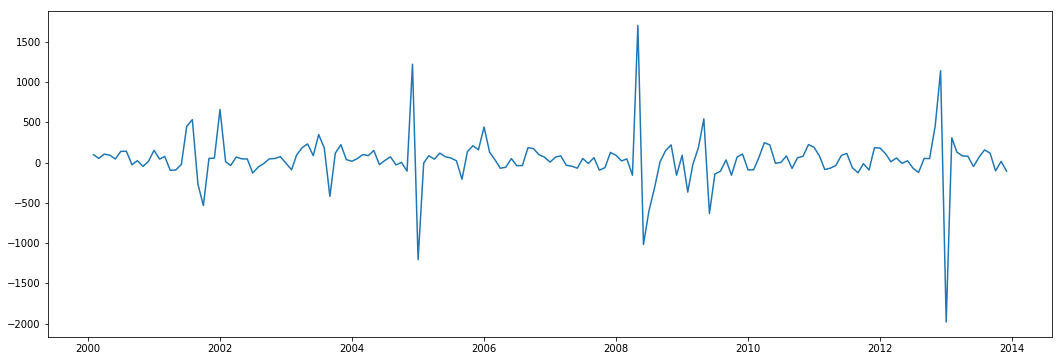

In [144]:
plt.figure(figsize=(18,6))
plt.plot(consump_diff)

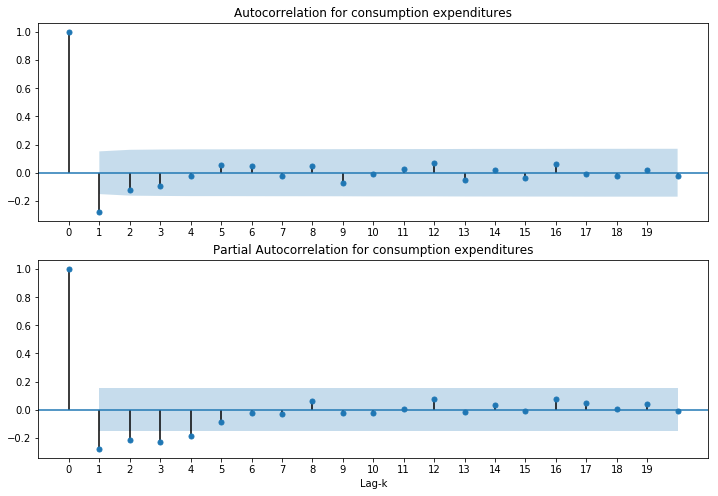

In [403]:
nlags = 20  #define number of lags to plot on ACF/PACF plots
fig = plt.figure(figsize=(12,8))
ax3 = fig.add_subplot(211)
fig = tsaplots.plot_acf(consump_diff, lags=nlags, ax=ax3,title='Autocorrelation for consumption expenditures')
plt.xticks(list(range(0,nlags)))

ax2 = fig.add_subplot(212)
fig = tsaplots.plot_pacf(consump_diff, lags=nlags, ax=ax2,title='Partial Autocorrelation for consumption expenditures')
plt.xticks(list(range(0,nlags)))
plt.xlabel('Lag-k')
plt.show()

plt.show()

#### Solution:- 
After we take the first difference of the series the plot shows reading around 0 with some shocks and when we plot the ACF/PACF plot of the first difference between the consump data we can see that it show stationary behaviour.  
To confirm that next we will do dickey fuller test.

#### d) Dickey Fuller test to test the hypothesis of unit-root non stationarity.

Null Hypothesis (H0): If accepted, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.     
Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure. We interpret this result using the p-value from the test.      
A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we accept the null hypothesis (non-stationary).      
p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.      
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.   

In [146]:
## for consump data 
result = adfuller(consump_data)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.919078
p-value: 0.323140
Critical Values:
	1%: -3.471
	5%: -2.879
	10%: -2.576


##### For Consump data 
Running the test statistic value of -1.919. As per ADF statistic we can see that our statistic value of -1.919 is greater than the value of -3.471 at 1%.       
The p-value is > 0.05.     
Comparing the p-value and test statistic to the critical values, it looks like we would have to Accept the null hypothesis (H0), the data has a unit root and is non-stationary and does have time-dependent structure.

In [147]:
result = adfuller(consump_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.014113
p-value: 0.000000
Critical Values:
	1%: -3.471
	5%: -2.879
	10%: -2.576


##### For first difference of Consump data 
Running the test statistic value of -10.014. As per ADF statistic we can see that our statistic value of -3.471 is less than the value of -3.471 at 1%.   
The p-value is <= 0.05.
Comparing the p-value and test statistic to the critical values, it looks like we would have to Reject the null hypothesis (H0), the data does not have a unit root and is stationary and does not have time-dependent structure.

We will now consider this data to make our model.

#### e) BIC order selection method to identify the order of the “best” ARIMA(p,1,d) model.

In [494]:
model_auto = pm.auto_arima(consump_diff, error_action='ignore',start_p = 2, start_q = 5, d=1,seasonal=True,m=12, information_criterion='bic')

In [495]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  167
Model:               SARIMAX(4, 1, 1)   Log Likelihood               -1176.890
Date:                Tue, 26 Feb 2019   AIC                           2367.780
Time:                        14:47:50   BIC                           2389.564
Sample:                             0   HQIC                          2376.622
                                - 167                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.7113      0.564     -1.260      0.208      -1.817       0.395
ar.L1         -0.4277      0.065     -6.557      0.000      -0.556      -0.300
ar.L2         -0.3429      0.082     -4.207      0.000      -0.503      -0.183
ar.L3         -0.2947      0.087     -3.372      0.001      -0.466      -0.123
ar.L4         -0.1852      0.091     -2.038      0.042      -0.363      -0.007
ma.L1         -1.0000     12.346     -0.081      0.935     -25.198      23.198
sigma2      8.082e+04   9.94e+05      0.081      0.935   -1.87e+06    2.03e+06
===================================================================================
Ljung-Box (Q):                       13.93   Jarque-Bera (JB):               881.90
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.01   Skew:                             1.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.03e+14. Standard errors may be unstable.
"""

#### Solution:-
As we can see that when we run the dickey fuller test on our data the got the stationarity when we used the first difference of the consump. So we use the auto arima function to find our best fit arima model which we got as ARIMA(4,1,1), where AR(p) = 4 and MA(q) = 1.   
We can see that from our plot also.

#### f) Fit the selected ARIMA model and plot residual analysis to check if model behaviour is dynamic.

In [484]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(consump_diff, order=(4,1,1))
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:              D.consump   No. Observations:                  166
Model:                 ARIMA(4, 1, 1)   Log Likelihood               -1176.968
Method:                       css-mle   S.D. of innovations            284.169
Date:                Tue, 26 Feb 2019   AIC                           2367.936
Time:                        14:46:00   BIC                           2389.720
Sample:                    03-01-2000   HQIC                          2376.778
                         - 12-01-2013                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.3163      0.207     -1.526      0.129      -0.723       0.090
ar.L1.D.consump    -0.4271      0.076     -5.603      0.000      -0.576      -0.278
ar.L2.D.consump    -0.3427      

In [497]:
residuals = model_fit.resid

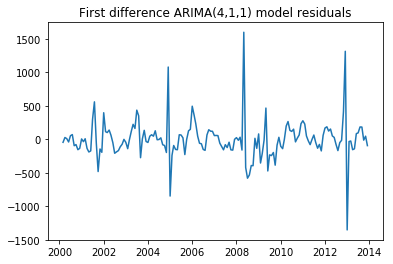

In [498]:
plt.figure(figsize=(6,4))
plt.plot(residuals)
plt.title("First difference ARIMA(4,1,1) model residuals")

#### Solution:-
As we can see above that the model has significant ar(p) and ma(q) values and all values have p-value < 0.05 and it's BIC value is 2389.720.   

As we can from the Residual Plot of the model the residual values show stationary behaviour and there are some shock which can be normalize if we try applying the log to first difference value but for now we will keep it like this.   

#### g) Write down the fitted model and discuss the trend captured by the model

ARIMA(4,1,1) = -0.3163 + (-0.4271)* v(t-1) + (-0.3427)* v(t-2) + (-0.2944)* v(t-3)+(-0.1849) * v(t-4) - (-1.0000)* a(t-1)   
d=1 shows trend is linear.


#### h) Backtesting procedures using 90% (=150 values) of the data for training and 10% for testing to evaluate the forecasting power of the fitted model.

#### Backtesting :
A simulation designed to test the performance of a set of trading and risk management rules on historical data.       

In [488]:
train = consump_diff[:150]
test = consump_diff[150:]
print("Training Data = {}\nTesting Data = {}".format(train.shape,test.shape))

Training Data = (150,)
Testing Data = (17,)


In [489]:
history = [x for x in train]
predictions = list()
originals = list()
error_list = list()

for t in range(len(test)):
    model = ARIMA(consump_diff, order=(4,1,1))
    model_fit = model.fit(disp=0)
    
    output = model_fit.forecast(steps=18)
    pred_value = output[0]
    original_value = test[t]
    history.append(original_value)

    error = ((abs(pred_value - original_value)) / original_value) * 100
    error_list.append(error)
    predictions = pred_value
    originals.append(float(original_value))

In [490]:
predicted_list = list()
original_list = list()
error_list = list()
print('Printing Predicted vs Expected Values...')
print('\n')

for i in range(17):
    pred = predictions[i]
    org = originals[i]
    error = ((abs(pred - org)) / org) * 100
    error_list.append(error)
    print('predicted = %f,   expected = %f,   error = %f ' % (pred, org, error), '%')
    predicted_list.append(pred)
    original_list.append(org)
print('\n Means Error in Predicting Test Case Articles (MAPE): %f ' % (sum(error_list)/float(len(error_list))), '%')

Printing Predicted vs Expected Values...


predicted = 69.767038,   expected = -124.000000,   error = -156.263740  %
predicted = 41.084505,   expected = 51.000000,   error = 19.442146  %
predicted = 6.032605,   expected = 49.000000,   error = 87.688561  %
predicted = 0.450280,   expected = 450.000000,   error = 99.899938  %
predicted = -10.111616,   expected = 1140.000000,   error = 100.886984  %
predicted = 11.226526,   expected = -1980.000000,   error = -100.566996  %
predicted = 13.148392,   expected = 307.000000,   error = 95.717136  %
predicted = 8.445867,   expected = 129.000000,   error = 93.452816  %
predicted = 4.754541,   expected = 82.000000,   error = 94.201779  %
predicted = 2.718862,   expected = 78.000000,   error = 96.514279  %
predicted = 5.171102,   expected = -50.000000,   error = -110.342204  %
predicted = 6.066706,   expected = 64.000000,   error = 90.520771  %
predicted = 5.414535,   expected = 157.000000,   error = 96.551251  %
predicted = 4.329170,   expected = 

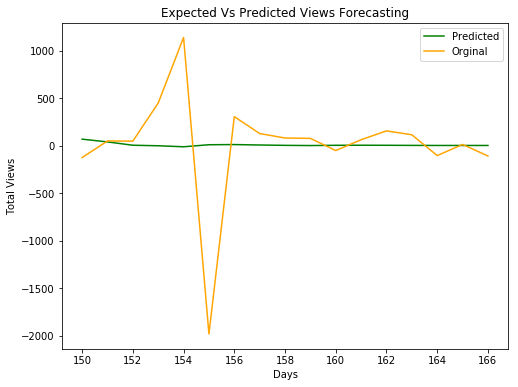

In [491]:
plt.figure(figsize=(8, 6))
test_day = [t+150
           for t in range(len(test))]
labels={'Predicted','Orginal'}
plt.plot(test_day, predicted_list, color= 'green')
plt.plot(test_day, original_list, color = 'orange')
plt.title('Expected Vs Predicted Views Forecasting')
plt.xlabel('Days')
plt.ylabel('Total Views')
plt.legend(labels)
plt.show()

In [502]:
n_train = 150
n_records = len(consump_diff)
predictions_back = []
for i in range(n_train, n_records):
    train, test = consump_data[0:i], consump_data[i:i+1]
    predictions_back.append(test)

#### Solution:-
After applying backtesting to the model we compared the predicted values and expected values so when we calculate the MAPE we got 27.73% which is very high so our next goal will be to reduce that value.

As we can see from the plot that the error for predicted value of shocks are very high which we need to fix.

### Problem 4

#### a) Goal of this problem is to define a time series model to predict monthly shipments

In [120]:
steel = pd.read_table("steel2.txt",index_col=False)
steel.columns = ['Shipment_in_tons']

In [121]:
print(steel.shape)
print(steel.head())

(95, 1)
   Shipment_in_tons
0              6150
1              7240
2              6472
3              6948
4              6686


#### Solution:-
The Dataset contain the records for metal shipment from U.S. companies in thousands of tons. As we can see that dataset contain that data value from year 1984 to 1991 i.e 8 years of data. Our goal is to forecast the data using time series model.

In [122]:
steel['Return'] = steel.pct_change()

In [123]:
steel['Log_value'] = log(steel['Shipment_in_tons'])

In [124]:
steel['Difference_value'] = steel['Shipment_in_tons'].diff()

In [125]:
steel['Difference_Log_value'] = steel['Log_value'].diff()

In [216]:
steel = steel.dropna()
steel.head(2)

,Shipment_in_tons,Return,Log_value,Difference_value,Difference_Log_value
1,7240,0.177236,8.887376,1090.0,0.163169
2,6472,-0.106077,8.775240,-768.0,-0.112136


#### b) Time Plot for online sales and the returns.

#### Sales time plot, histogram and q-q plot

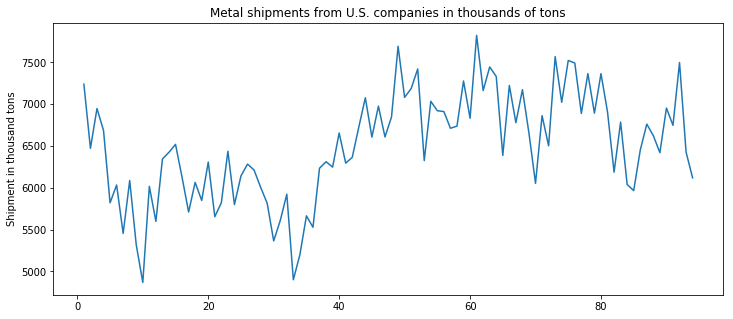

In [127]:
plt.figure(figsize=(12,5))
plt.ylabel("Shipment in thousand tons")
plt.title("Metal shipments from U.S. companies in thousands of tons")
plt.plot(steel.Shipment_in_tons)

In [128]:
print("Variance of the dataset = {}".format(np.var(a=steel.Shipment_in_tons)))

Variance of the dataset = 411045.2893843368


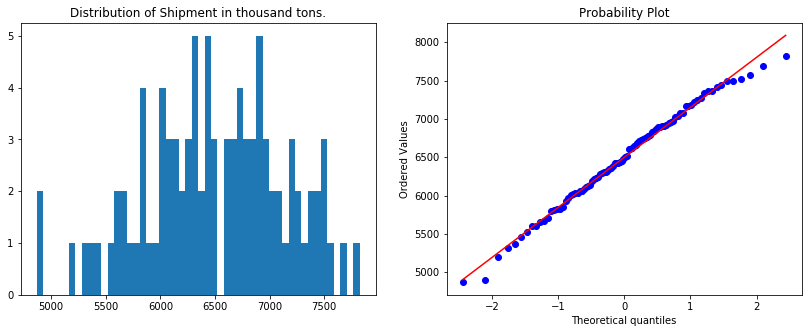

In [129]:
statsmodels.tsa.seasonal.seasonal_decompose(x, model='additive', plt.figure(figsize=(14,5))
plt.subplot(121)
plt.hist(steel['Shipment_in_tons'],bins=50)
plt.title('Distribution of Shipment in thousand tons.')

plt.subplot(122)
stats.probplot(steel['Shipment_in_tons'],plot=plt)
plt.show()

#### Solutions:-
As we can see from the plot that the data has values between 7500 and 5000. We cannot justify that data look stationary just from the plot so we calculated the variance and plotted the histogram and q-q plot.   

Variance: The variance for this data is much higher as values are larger and it keeps on changing.    

Histogram and Q-Qplot: Histogram plot shows that values are spread out evenly all over so it shows some skewness. Q-Q plot show that data is normally distributed.

Now we will try to see how the data react when we apply log to the data and we will also see the return of the data.

#### Sales return time plot, histogran and q-q plot

#### log(sales), diff(log_value), log(first difference) time plot, histogran and q-q plot

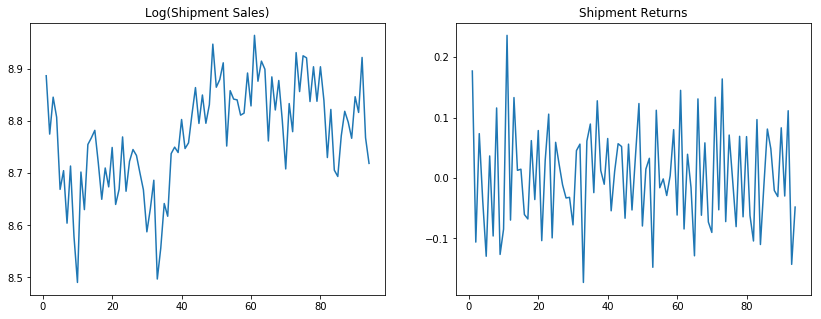

In [130]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(steel['Log_value'])
plt.title('Log(Shipment Sales)')

plt.subplot(122)
plt.plot(steel['Return'])
plt.title('Shipment Returns')
plt.show()

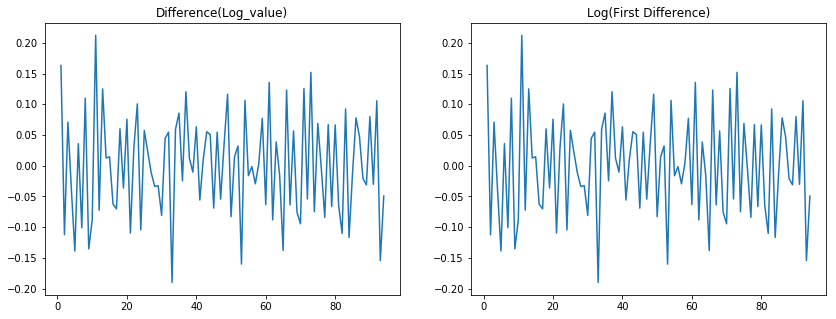

In [131]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(steel['Difference_Log_value']) 
plt.title('Difference(Log_value)')

plt.subplot(122)
plt.plot(steel['Difference_Log_value']) 
plt.title('Log(First Difference)')
plt.show()

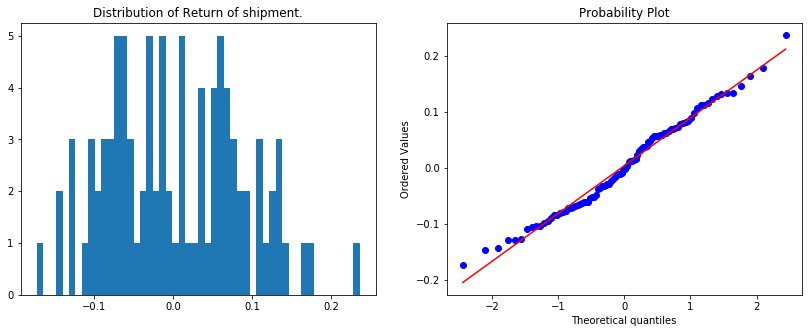

In [132]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.hist(steel['Return'],bins=50)
plt.title('Distribution of Return of shipment.')

plt.subplot(122)
stats.probplot(steel['Return'],plot=plt)
plt.show()

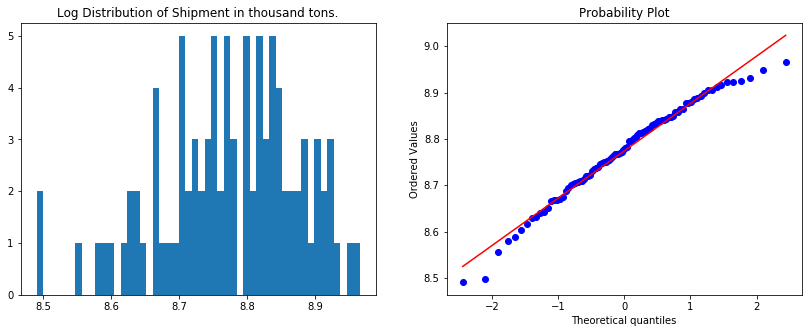

In [133]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.hist(steel['Log_value'],bins=50)
plt.title('Log Distribution of Shipment in thousand tons.')

plt.subplot(122)
stats.probplot(steel['Log_value'],plot=plt)
plt.show()

#### c) ACF of Xt(shipment sales) and of its first difference (returns)

After considering the return and log value of the shipment sales we will plot ACF graph for those to see the seasonality and stationarity of the series.   
We will plot the ACF/PACF for those of the following check the title to see which plots it is.

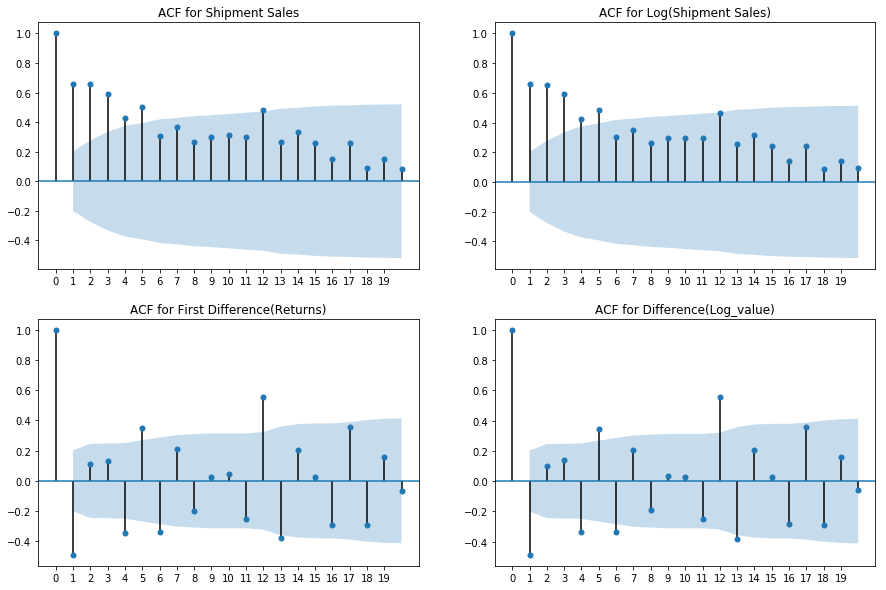

In [134]:
nlags = 20  #define number of lags to plot on ACF/PACF plots

fig = plt.figure(figsize=(15,10))

ax1 = plt.subplot(2, 2, 1)
fig = tsaplots.plot_acf(steel.Shipment_in_tons, ax = ax1, lags=nlags, title='ACF for Shipment Sales')
plt.xticks(list(range(0,nlags)))

ax2 = plt.subplot(2, 2, 2)
fig = tsaplots.plot_acf(steel.Log_value, lags=nlags, ax = ax2, title='ACF for Log(Shipment Sales)')
plt.xticks(list(range(0,nlags)))

ax3 = plt.subplot(2, 2, 3)
fig = tsaplots.plot_acf(steel.Return, lags=nlags, ax = ax3, title='ACF for First Difference(Returns)')
plt.xticks(list(range(0,nlags)))

ax4 = plt.subplot(2, 2, 4)
fig = tsaplots.plot_acf(steel.Difference_Log_value, lags=nlags,ax = ax4, title='ACF for Difference(Log_value)')
plt.xticks(list(range(0,nlags)))

plt.show()

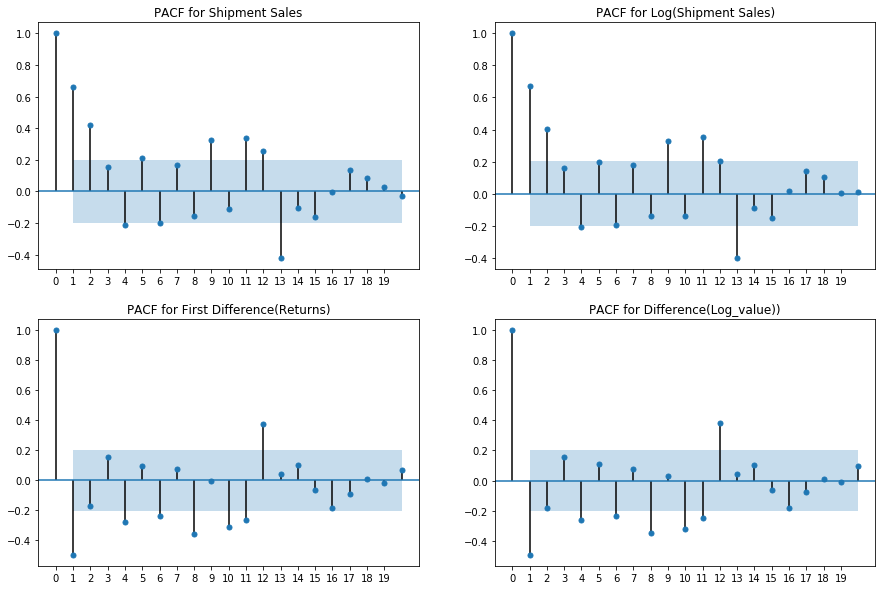

In [135]:
nlags = 20  #define number of lags to plot on ACF/PACF plots

fig = plt.figure(figsize=(15,10))

ax1 = plt.subplot(2, 2, 1)
fig = tsaplots.plot_pacf(steel.Shipment_in_tons, ax = ax1, lags=nlags, title='PACF for Shipment Sales')
plt.xticks(list(range(0,nlags)))

ax2 = plt.subplot(2, 2, 2)
fig = tsaplots.plot_pacf(steel.Log_value, lags=nlags, ax = ax2, title='PACF for Log(Shipment Sales)')
plt.xticks(list(range(0,nlags)))

ax3 = plt.subplot(2, 2, 3)
fig = tsaplots.plot_pacf(steel.Return, lags=nlags, ax = ax3, title='PACF for First Difference(Returns)')
plt.xticks(list(range(0,nlags)))

ax4 = plt.subplot(2, 2, 4)
fig = tsaplots.plot_pacf(steel.Difference_Log_value, lags=nlags,ax = ax4, title='PACF for Difference(Log_value))')
plt.xticks(list(range(0,nlags)))

plt.show()

#### Solution:-
After plotting ACF/PACF plot for Shipment sales, Log(shipment sales), First difference(returns), difference(log_value). We can see that plot for return and difference of log_value is same.  
We will consider the value of Return for further in model building as it show stationarity, less trend and seasonality.

#### d) is time series stationary after de-trending and de-seasonalizing

In [136]:
result = adfuller(steel.Return)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.901063
p-value: 0.045225
Critical Values:
	1%: -3.513
	5%: -2.897
	10%: -2.586


As we can see from the dickey fuller test and ACF/PACF plot that return values show sign of stationarity.  

The p-value that we got from the dickey fuller test is (< 0.05) which suggest that we can reject the null hypothesis and we can say that data is stationary and doesn not have unit roots.

The ADF statistics value is more negative that 5% and 10% critical value which show that data is significant for 99% CI and only 1% data is not.

#### e) seasonal multiplicative model

In [228]:
model_auto = pm.auto_arima(steel.Return, error_action='ignore',seasonal=True,m=12, information_criterion='bic')

In [229]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   94
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                 133.529
Date:                            Wed, 27 Feb 2019   AIC                           -259.058
Time:                                    22:45:57   BIC                           -248.884
Sample:                                         0   HQIC                          -254.948
                                             - 94                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0008      0.005      0.177      0.860      -0.008       0.010
ar.L1         -0.4072      0.111     -3.661      0.000      -0.625      -0.189
ar.S.L12       0.6747      0.071      9.462      0.000       0.535       0.814
sigma2         0.0032      0.000      6.878      0.000       0.002       0.004
===================================================================================
Ljung-Box (Q):                       57.22   Jarque-Bera (JB):                 1.75
Prob(Q):                              0.04   Prob(JB):                         0.42
Heteroskedasticity (H):               0.76   Skew:                            -0.33
Prob(H) (two-sided):                  0.46   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [184]:
model = SARIMAX(steel.Return,order=(1,0,0), seasonal_decompose=(1,0,0,12))
results = model.fit()

In [185]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                 Return   No. Observations:                   94
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 112.577
Date:                Wed, 27 Feb 2019   AIC                           -221.154
Time:                        20:32:46   BIC                           -216.067
Sample:                             0   HQIC                          -219.099
                                 - 94                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5070      0.101     -5.042      0.000      -0.704      -0.310
sigma2         0.0053      0.001      6.495      0.000       0.004       0.007
===================================================================================
Ljung-Box (Q):                      108.53   Jarque-Bera (JB):                 0.21
Prob(Q):                              0.00   Prob(JB):                         0.90
Heteroskedasticity (H):               0.83   Skew:                            -0.07
Prob(H) (two-sided):                  0.61   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

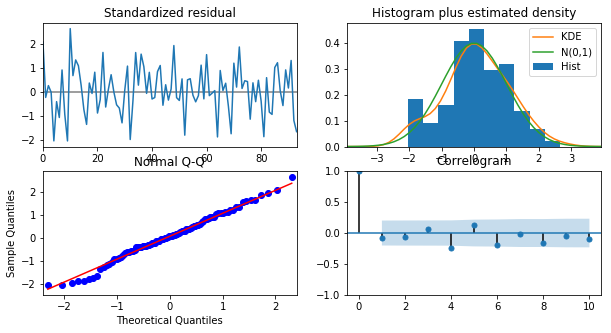

In [186]:
results.plot_diagnostics(figsize=(10, 5))
plt.show()

#### f) Expression of selected model

The model includes a non-seasonal AR(1) term, a seasonal AR(1) term, no differencing, no MA terms and the seasonal period is S = 12.     
The non-seasonal AR(1) polynomial is φ(B) = 1 - φ1B.    
The seasonal AR(1) polynomial is Φ(B12) = 1 - Φ1*(B^12).    
The model is (1 - Φ1(B^12))(1 - φ1B)(xt - μ) = wt.    

Now, let zt = xt - μ    
zt = φ1*z(t-1) + Φ1*z(t-12) + (-Φ1φ1)*z(t-13) + wt.     
   
Seasonal_ARIMA(1,0,0)*(1,0,0,12) =  (-0.5)*z(t-1) + Φ1*z(t-12) + (-(0.005)*(-0.5))*z(t-13) + wt    
                                 =  (-0.5)*z(t-1) + Φ1*z(t-12) + (0.0025)*z(t-13) + wt 

#### g) forecast the shipments for the next 4 months

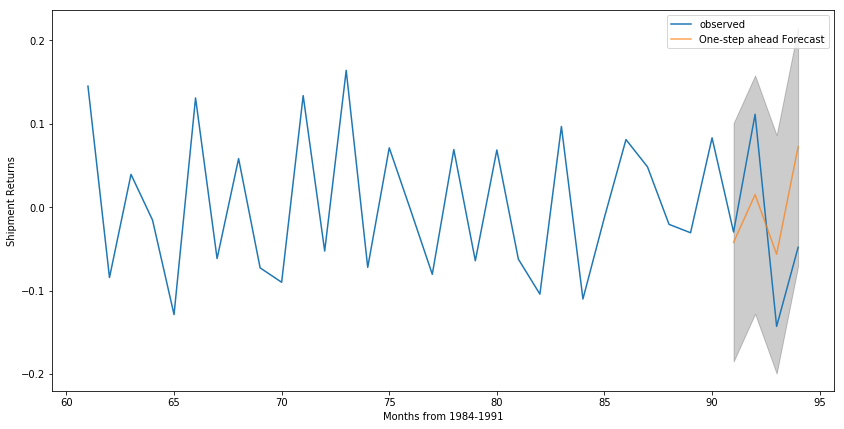

In [187]:
pred = results.get_prediction(start=90, dynamic=False)
pred_ci = pred.conf_int()
ax = steel.Return[60:].plot(label='observed')  ## you can adjust the slice value, I will keep it 60 for now
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Months from 1984-1991')
ax.set_ylabel('Shipment Returns')
plt.legend()
plt.show()

In [188]:
y_forecasted = pred.predicted_mean
y_truth = steel.Return[90:]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 0.01
The Root Mean Squared Error of our forecasts is 0.09


#### Solution:-
So after we build and fit the model we will use that model in forecasting so for now we will test that model by training and testing the data. So from the previous data I used the 90 rows to train the model and 6 rows to test it.  
So as we can see from the plot that series forecasted has MSE of 0.01 and RMSE of 0.09 which is good for the model. 

So we will now forecast the next 4 months after this to predict the sales return. As you can see below we select the step = 4 to predict the forecast for next 4 months of the Shipment sales Return. 

#### h) plot the forecast 

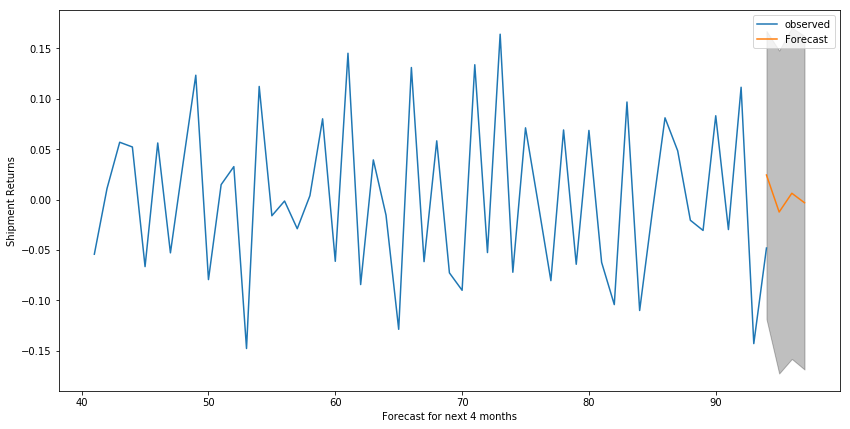

In [190]:
pred_uc = results.get_forecast(steps=4)
pred_ci = pred_uc.conf_int()
ax = steel.Return[40:].plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Forecast for next 4 months')
ax.set_ylabel('Shipment Returns')
plt.legend()
plt.show()

As we seen above for the plot above that forecast looks consistent with the plot.

So we get this good result because we made the series stationary by de-trending and de-seasonlizing the series. Due to stationarity we get achive our result by building simple model. So we can say that more stationary the series better the results.